Reproducing the [notebook](https://github.com/muellerzr/Conference_Posters/blob/master/Talks/The%20fastai%20API%20and%20You/01_Image_Classification.ipynb) created by [muellerzr](https://github.com/muellerzr) and also collect all the different techniques into one notebook

**Techniques**
- ranger as an optimizer, a mix of LookAhead and AdamW instead of the default AdamW
- MixUp during training by adding it as a callback
  `learn.fine_tune(1, cbs=[MixUp()]`
- Apply labelsmoothing as regularization
- Test Time Augmentation

**Results**

Experiment | Accuracy 
-----------| ------
resnet34 with CrossEntropy |  0.944515
resnet34 with LabelSmooting | 
resnet34 with MixUp | 
resnet34 with CrossEntropy + TTA |


 

Performing image classification on [ImageWoof](https://github.com/fastai/imagenette) dataset. This is a subset of ImageNet containing 10 different dog breeds.

## Outline
- Install & Import the library
- Applying DataBlock 
- Create a baseline using Resnet34 model
- Showing examples using techniques such as MixUp and Test Time-Augmentation

## Install and Import the library

With pytorch, different releases are published are based on the computation backends such as (CPU, CUDA). One has to install appropriate pytorch version based on CUDA version. light-the-torch package simplifies the problem.

In [ ]:
%%capture
!pip install light-the-torch
!ltt install torch torchvision
!pip install fastai==2.1.4 fastcore==1.3.2 nbdev --upgrade

#Ensure that you restart the runtime if it still shows the old version.

In [ ]:
#Enable this variable if you want to run fine_tune
FINE_TUNE=False

We will use vision module in the fastai library.

In [ ]:
import fastai
fastai.__version__

'2.1.4'

In [ ]:
from fastai.vision.all import *

## Applying the DataBlock

In [ ]:
#Download the data
path = untar_data(URLs.IMAGEWOOF)

Let's look at how this dataset is structured.

In [ ]:
path.ls()

(#2) [Path('/root/.fastai/data/imagewoof2/val'),Path('/root/.fastai/data/imagewoof2/train')]

There are two directories containing training and validation files.

The training directory contains a list of directories containinig images corresponding to a particular breed.

In [ ]:
(path/'train').ls()[:2]

(#2) [Path('/root/.fastai/data/imagewoof2/train/n02086240'),Path('/root/.fastai/data/imagewoof2/train/n02099601')]

The directory names contain the labels.

In [ ]:
# Defining the datablock to prepare for modeling
dblk = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = GrandparentSplitter(train_name='train', valid_name='val'),
    get_y = parent_label,
    item_tfms = [Resize(size=448, method='crop')], #data augmentation see more here https://docs.fast.ai/vision.augment.html
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
)

In [ ]:
#Let's pass a single directory 
dblk.summary((path/'train').ls()[0])

Setting-up type transforms pipelines
Found 941 items
2 datasets of sizes 941,0
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/imagewoof2/train/n02086240/n02086240_846.JPEG
    applying PILBase.create gives
      PILImage mode=RGB size=500x332
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/imagewoof2/train/n02086240/n02086240_846.JPEG
    applying parent_label gives
      n02086240
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=500x332, TensorCategory(0))


Setting up after_item: Pipeline: Resize -- {'size': (448, 448), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipe

From the above, we can observe it sets a pipeline for X and y. And to perform a transformation on y it first applies `parent_label`(get the name of directory containing this file) followed by `Categorize` and converting it to TensorCategory.


```
 Pipeline: parent_label -> Categorize -- 
{'vocab': None, 'sort': True, 'add_na': False}
    
    starting from
      /root/.fastai/data/imagewoof2/train/n02096294/n02096294_1539.JPEG

    applying parent_label gives
      n02096294

    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)
```

fastai provides **Transform** pipeline construct that allows not only to augment the data but also allows one to change the folder name into a more readable one.

In [ ]:
label_dict = dict(
    n02086240= 'Shih-Tzu',
    n02087394= 'Rhodesian ridgeback',
    n02088364= 'Beagle',
    n02089973= 'English foxhound',
    n02093754= 'Australian terrier',
    n02096294= 'Border terrier',
    n02099601= 'Golden retriever',
    n02105641= 'Old English sheepdog',
    n02111889= 'Samoyed',
    n02115641= 'Dingo'
)

In [ ]:
label_dict

{'n02086240': 'Shih-Tzu',
 'n02087394': 'Rhodesian ridgeback',
 'n02088364': 'Beagle',
 'n02089973': 'English foxhound',
 'n02093754': 'Australian terrier',
 'n02096294': 'Border terrier',
 'n02099601': 'Golden retriever',
 'n02105641': 'Old English sheepdog',
 'n02111889': 'Samoyed',
 'n02115641': 'Dingo'}

In [ ]:
item = (path/'train').ls()[0]
item.name, label_dict[item.name], label_dict.__getitem__(item.name) 

('n02086240', 'Shih-Tzu', 'Shih-Tzu')

Adding this as part of transformation to the target using get_y

In [ ]:
# Pipeline is composed of functions/transforms for encoding/decoding purpose.
get_y = Pipeline([parent_label, label_dict.__getitem__])

Let's rewrite the datablock and run the summary if it transform the y as we expected.

In [ ]:
dblk = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = GrandparentSplitter(train_name='train', valid_name='val'),
    get_y = get_y,
    item_tfms = [Resize(size=448, method='crop')], #data augmentation see more here https://docs.fast.ai/vision.augment.html
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
)

In [ ]:
dblk.summary((path/'train').ls()[0])

Setting-up type transforms pipelines
Found 941 items
2 datasets of sizes 941,0
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> dict.__getitem__ -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/imagewoof2/train/n02086240/n02086240_846.JPEG
    applying PILBase.create gives
      PILImage mode=RGB size=500x332
  Pipeline: parent_label -> dict.__getitem__ -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/imagewoof2/train/n02086240/n02086240_846.JPEG
    applying parent_label gives
      n02086240
    applying dict.__getitem__ gives
      Shih-Tzu
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=500x332, TensorCategory(0))


Setting up after_item: Pipeline: Resize -- {'size': (448, 448), 'method': 'crop', 'pad_mo

As we can see, we have introduced an additional transform and converted the y from n02096294 to Border terrier
```
Pipeline: parent_label -> dict.__getitem__ -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

    starting from
      /root/.fastai/data/imagewoof2/train/n02096294/n02096294_1539.JPEG

    applying parent_label gives
      n02096294

    applying dict.__getitem__ gives
      Border terrier

    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)
```

In [ ]:
aug_transforms(size=224, min_scale=0.75)

[Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
 encodes: (TensorImage,object) -> encodes
 decodes: ,
 RandomResizedCropGPU -- {'size': (224, 224), 'min_scale': 0.75, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'p': 1.0}:
 encodes: (TensorImage,object) -> encodes
 decodes: ]

In [ ]:
#If you want more fine grained control,explictly define your batch tfms

# batch_tfms = [FlipItem(), RandomResizedCrop(128, min_scale=0.35),
#                   Normalize.from_stats(*imagenet_stats)
#                   ]

# Or go with the defaults
#batch_tfms = [aug_transforms(size=128, min_scale=0.75)]

In [ ]:
# Defining the datablock to prepare for modeling
dblk = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = GrandparentSplitter(train_name='train', valid_name='val'),
    get_y = get_y,
    #Resize images to relatively “large” dimensions
    item_tfms = [Resize(size=448, method='crop')], 
    #data augmentation see more here https://docs.fast.ai/vision.augment.html
    batch_tfms = [FlipItem(), RandomResizedCrop(128, min_scale=0.35),
                  Normalize.from_stats(*imagenet_stats)
                  ]
)

In [ ]:
dblk.summary(path)

Setting-up type transforms pipelines
Found 12954 items
2 datasets of sizes 9025,3929
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> dict.__getitem__ -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/imagewoof2/train/n02086240/n02086240_846.JPEG
    applying PILBase.create gives
      PILImage mode=RGB size=500x332
  Pipeline: parent_label -> dict.__getitem__ -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/imagewoof2/train/n02086240/n02086240_846.JPEG
    applying parent_label gives
      n02086240
    applying dict.__getitem__ gives
      Shih-Tzu
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(9)

Final sample: (PILImage mode=RGB size=500x332, TensorCategory(9))


Setting up after_item: Pipeline: Resize -- {'size': (448, 448), 'method': 'crop', '

In [ ]:
dls = dblk.dataloaders(path, bs=64)

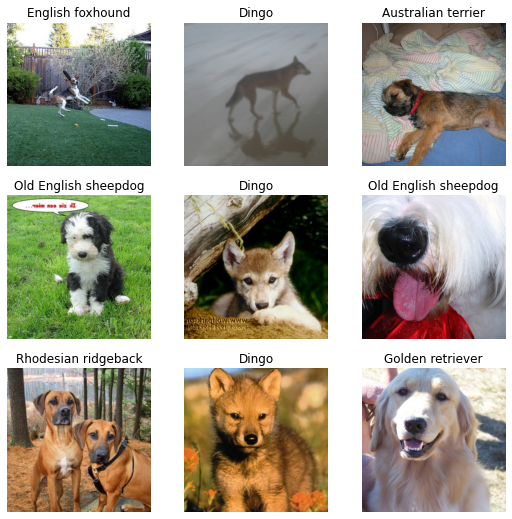

In [ ]:
dls.show_batch()

In [ ]:
b = dls.one_batch()

In [ ]:
len(b), b[0].shape, b[0][0].shape

(2, torch.Size([64, 3, 448, 448]), torch.Size([3, 448, 448]))

## Baseline using Resnet34

We can leverage Transfer Learning to speed up the training and also improve the metrics.

fastai provides Learner object which wraps the dataloaders, architecture, hyperparameters, metrics etc.

For images, we can use cnn_learner(Convolutional Neural Network)

In [ ]:
learn = cnn_learner(dls, arch=resnet34, metrics=accuracy, loss_func=CrossEntropyLossFlat())

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Learner by default tries to download the pretrained weights for resnet architecture and apply custom head on top. Let's look at the model summary.

In [ ]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

## Experiment 1 - Baseline

In [ ]:
if FINE_TUNE:
  learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.468834,0.210816,0.939425,02:49


epoch,train_loss,valid_loss,accuracy,time
0,0.262372,0.188912,0.944515,03:38


## Experiment 2 - LR Finder, Discriminative LR, Mixed Precision, Resnet 50

In [ ]:
learn = cnn_learner(dls, arch=resnet50, metrics=accuracy, loss_func=CrossEntropyLossFlat()).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0003311311302240938)

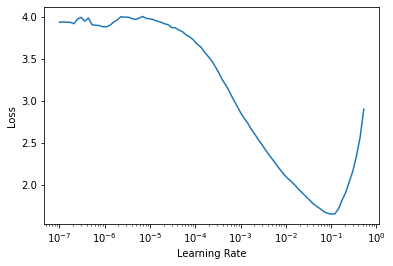

In [ ]:
learn.lr_find()

In [ ]:
FINE_TUNE=True
if FINE_TUNE:
  learn.fine_tune(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.333751,0.282139,0.931280,03:27


epoch,train_loss,valid_loss,accuracy,time
0,0.582499,0.896619,0.761517,04:05
1,0.384746,0.459956,0.869941,04:03
2,0.165085,0.246784,0.933571,04:02


SuggestedLRs(lr_min=3.311311302240938e-05, lr_steep=1.0964781722577754e-06)

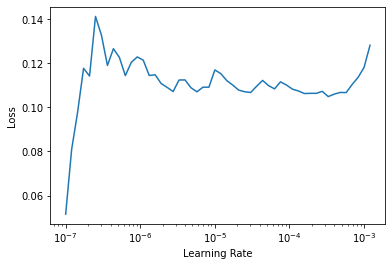

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, slice(1e-5, 5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.121878,0.230724,0.937134,04:03
1,0.076736,0.243553,0.934334,04:03
2,0.055963,0.231417,0.938916,04:02


The performance seemse to be much lower than the resnet34.

## Experiment 2a 

Change the loss function with label smoothing applied

In [ ]:
doc(LabelSmoothingCrossEntropyFlat)

From 
https://rickwierenga.com/blog/machine%20learning/LabelSmoothing.html

> Label smoothing is a variation on one hot encoding where the negative labels have a value slightly higher than 0, say 0.1  and the positive labels have a value slightly lower than 1, say 0.9


```
class LabelSmoothingCrossEntropy(Module):
    y_int = True
    def __init__(self, eps:float=0.1, reduction='mean'): self.eps,self.reduction = eps,reduction

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1) #We divide by that size at the return line so sum and not mean
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target.long(), reduction=self.reduction)

    def activation(self, out): return F.softmax(out, dim=-1)
    def decodes(self, out):    return out.argmax(dim=-1)
```

```
@delegates()
class LabelSmoothingCrossEntropyFlat(BaseLoss):
    "Same as `LabelSmoothingCrossEntropy`, but flattens input and target."
    y_int = True
    @use_kwargs_dict(keep=True, eps=0.1, reduction='mean')
    def __init__(self, *args, axis=-1, **kwargs): super().__init__(LabelSmoothingCrossEntropy, *args, axis=axis, **kwargs)
    def activation(self, out): return F.softmax(out, dim=-1)
    def decodes(self, out):    return out.argmax(dim=-1)
```

In [ ]:
del learn

In [ ]:
learn = cnn_learner(dls, arch=resnet34, metrics=accuracy, loss_func=LabelSmoothingCrossEntropyFlat())

In [ ]:
learn.loss_func

FlattenedLoss of LabelSmoothingCrossEntropy()

In [ ]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.172003,0.827896,0.927971,02:48


epoch,train_loss,valid_loss,accuracy,time
0,0.874614,0.734942,0.938916,03:38


## Experiment 3 - Mixup

Source: https://towardsdatascience.com/2-reasons-to-use-mixup-when-training-yor-deep-learning-models-58728f15c559

Mixup is a form of regularization technique. The idea is instead of passing raw images to your model, you pass a blend of 2 images from your training set. 

newImage = alpha * image1 + (1-alpha) * image2

But 

In [ ]:
doc(MixUp)

In [ ]:
learn = cnn_learner(dls, arch=resnet34, metrics=accuracy, loss_func=CrossEntropyLossFlat())

In [ ]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
learn.fine_tune(1, cbs=MixUp())

epoch,train_loss,valid_loss,accuracy,time
0,1.421824,0.240442,0.930008,02:49


epoch,train_loss,valid_loss,accuracy,time
0,1.046022,0.199377,0.942225,03:38


## Experiment 4 - Test Time Augmentation

 This is a type of data augmentation. By selecting a number of areas to crop from the original rectangular image, pass each of them through our model, and take the **maximum** or **average** of the predictions. 
- `preds, _ = learn.tta(dl=test_dl, beta=0)`

In [ ]:
show_doc(Learner.tta)

NameError: ignored

In [ ]:
item = get_image_files(path)[0]
learn.predict(item)

('Shih-Tzu',
 TensorImage(9),
 TensorImage([5.8873e-04, 4.8669e-04, 3.7679e-04, 9.7221e-04, 8.8172e-04, 2.8819e-03,
         4.1782e-04, 3.6273e-04, 9.0794e-04, 9.9212e-01]))

Returning the classname, class index & probabilities

In [ ]:
tta_preds = learn.tta(ds_idx=1)

In [ ]:
preds = learn.get_preds(ds_idx = 1)

In [ ]:
doc(accuracy)

In [ ]:
len(preds), len(preds[0]), len(preds[1])

(2, 3929, 3929)

In [ ]:
preds[0][0], preds[1][0]

(TensorImage([5.8873e-04, 4.8669e-04, 3.7679e-04, 9.7222e-04, 8.8172e-04, 2.8819e-03,
         4.1782e-04, 3.6273e-04, 9.0794e-04, 9.9212e-01]), TensorCategory(9))

In [ ]:
accuracy(*preds)

TensorImage(0.9422)

In [ ]:
accuracy(*tta_preds)

TensorImage(0.9443)

## Experiment 5

- Native Mixed Precision `to_native_fp16()` during training and back to `to_native_fp32` before export